# Experiment 6: Explicit Priors with Pixel2Mesh++

In [1]:
import pandas as pd

In [2]:
results = pd.read_csv("../eval/TestEvaluation/mesh_eval_results.csv")

In [3]:
relevant_models = [
    "refine_p2mp_augmentation_2_inputs_use_spherical_prior",
    "refine_p2mpp_augmentation_2_inputs_use_mean_prior",
    "refine_p2mpp_augmentation_2_inputs",
    # extend with Pixel2Mesh++ and PixelNeRF names as in the CSV file
]

filtered = results[results["model"].isin(relevant_models)]

aggregated = filtered.groupby("model", as_index=False).agg(
    mean_chamfer=("chamfer", "mean"),
    std_chamfer=("chamfer", "std"),
    mean_fscore_1=("fscore_1", "mean"),
    std_fscore_1=("fscore_1", "std"),
    mean_fscore_2_5=("fscore_2_5", "mean"),
    std_fscore_2_5=("fscore_2_5", "std"),
    mean_fscore_5=("fscore_5", "mean"),
    std_fscore_5=("fscore_5", "std"),
    mean_iou=("voxel_iou", "mean"),
    std_iou=("voxel_iou", "std"),
)

aggregated

,model,mean_chamfer,std_chamfer,mean_fscore_1,std_fscore_1,mean_fscore_2_5,std_fscore_2_5,mean_fscore_5,std_fscore_5,mean_iou,std_iou


In [4]:
import numpy as np
import trimesh

ell = np.load("../Pixel2MeshPlusPlus/data/iccv_p2mpp.dat", allow_pickle=True)

ellipoide = trimesh.Trimesh(
    vertices=ell["coord"], faces=ell["faces_triangle"][0]
).show()

In [5]:
# load mean_pollen_shape.stl from ../data/Pixel2MeshPlusPlus
mean_shape = trimesh.load_mesh("../Pixel2MeshPlusPlus/data/mean_pollen_shape.stl")
mean_shape.show()

In [6]:
unit_sphere = trimesh.load_mesh("../notebooks/priors/unit_sphere_prior.stl")
unit_sphere.show()

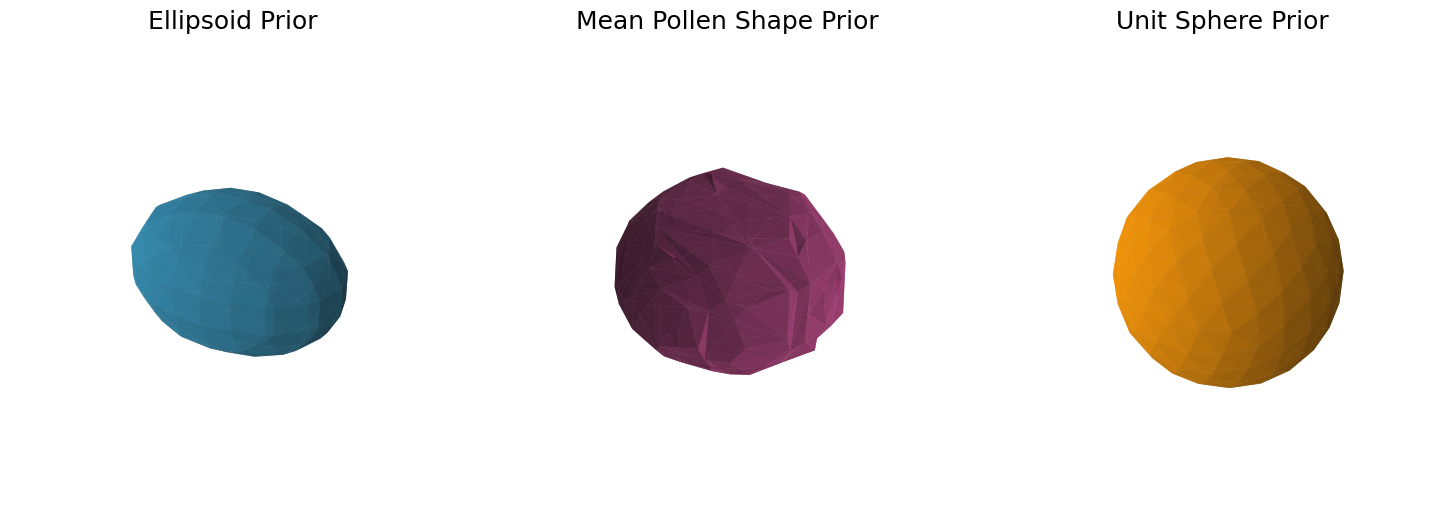

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import trimesh

# Load all three priors
# 1. Ellipsoid from iccv_p2mpp.dat
ell = np.load("../Pixel2MeshPlusPlus/data/iccv_p2mpp.dat", allow_pickle=True)
ellipsoid = trimesh.Trimesh(vertices=ell["coord"], faces=ell["faces_triangle"][0])

# 2. Mean pollen shape
mean_shape = trimesh.load_mesh("../Pixel2MeshPlusPlus/data/mean_pollen_shape.stl")

# 3. Unit sphere
unit_sphere = trimesh.load_mesh("../notebooks/priors/unit_sphere_prior.stl")

# Set up the figure with 3 subplots
fig = plt.figure(figsize=(15, 5))
colors_priors = [
    "#2E86AB",
    "#A23B72",
    "#F18F01",
]  # Green, Magenta, Yellow for the three priors

# Plot 1: Ellipsoid
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot_trisurf(
    ellipsoid.vertices[:, 0],
    ellipsoid.vertices[:, 1],
    ellipsoid.vertices[:, 2],
    triangles=ellipsoid.faces,
    color=colors_priors[0],  # Green
    alpha=0.8,
)
ax1.set_title("Ellipsoid Prior", fontsize=18, pad=20)
ax1.axis("off")

# Plot 2: Mean Pollen Shape
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot_trisurf(
    mean_shape.vertices[:, 0],
    mean_shape.vertices[:, 1],
    mean_shape.vertices[:, 2],
    triangles=mean_shape.faces,
    color=colors_priors[1],  # Magenta
    alpha=0.8,
)
ax2.set_title("Mean Pollen Shape Prior", fontsize=18, pad=20)
ax2.axis("off")

# Plot 3: Unit Sphere
ax3 = fig.add_subplot(133, projection="3d")
ax3.plot_trisurf(
    unit_sphere.vertices[:, 0],
    unit_sphere.vertices[:, 1],
    unit_sphere.vertices[:, 2],
    triangles=unit_sphere.faces,
    color=colors_priors[2],  # Yellow
    alpha=0.8,
)
ax3.set_title("Unit Sphere Prior", fontsize=18, pad=20)
ax3.axis("off")

# Set equal aspect ratio for all plots
for ax in [ax1, ax2, ax3]:
    # Get the range of each axis
    x_range = ax.get_xlim3d()
    y_range = ax.get_ylim3d()
    z_range = ax.get_zlim3d()

    # Calculate the center and range
    x_center = np.mean(x_range)
    y_center = np.mean(y_range)
    z_center = np.mean(z_range)

    max_range = (
        max(x_range[1] - x_range[0], y_range[1] - y_range[0], z_range[1] - z_range[0])
        / 2
    )

    # Set equal aspect ratio
    ax.set_xlim3d([x_center - max_range, x_center + max_range])
    ax.set_ylim3d([y_center - max_range, y_center + max_range])
    ax.set_zlim3d([z_center - max_range, z_center + max_range])

    # Force equal aspect ratio for truly spherical appearance
    ax.set_box_aspect([1, 1, 1])

# Set transparent background
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

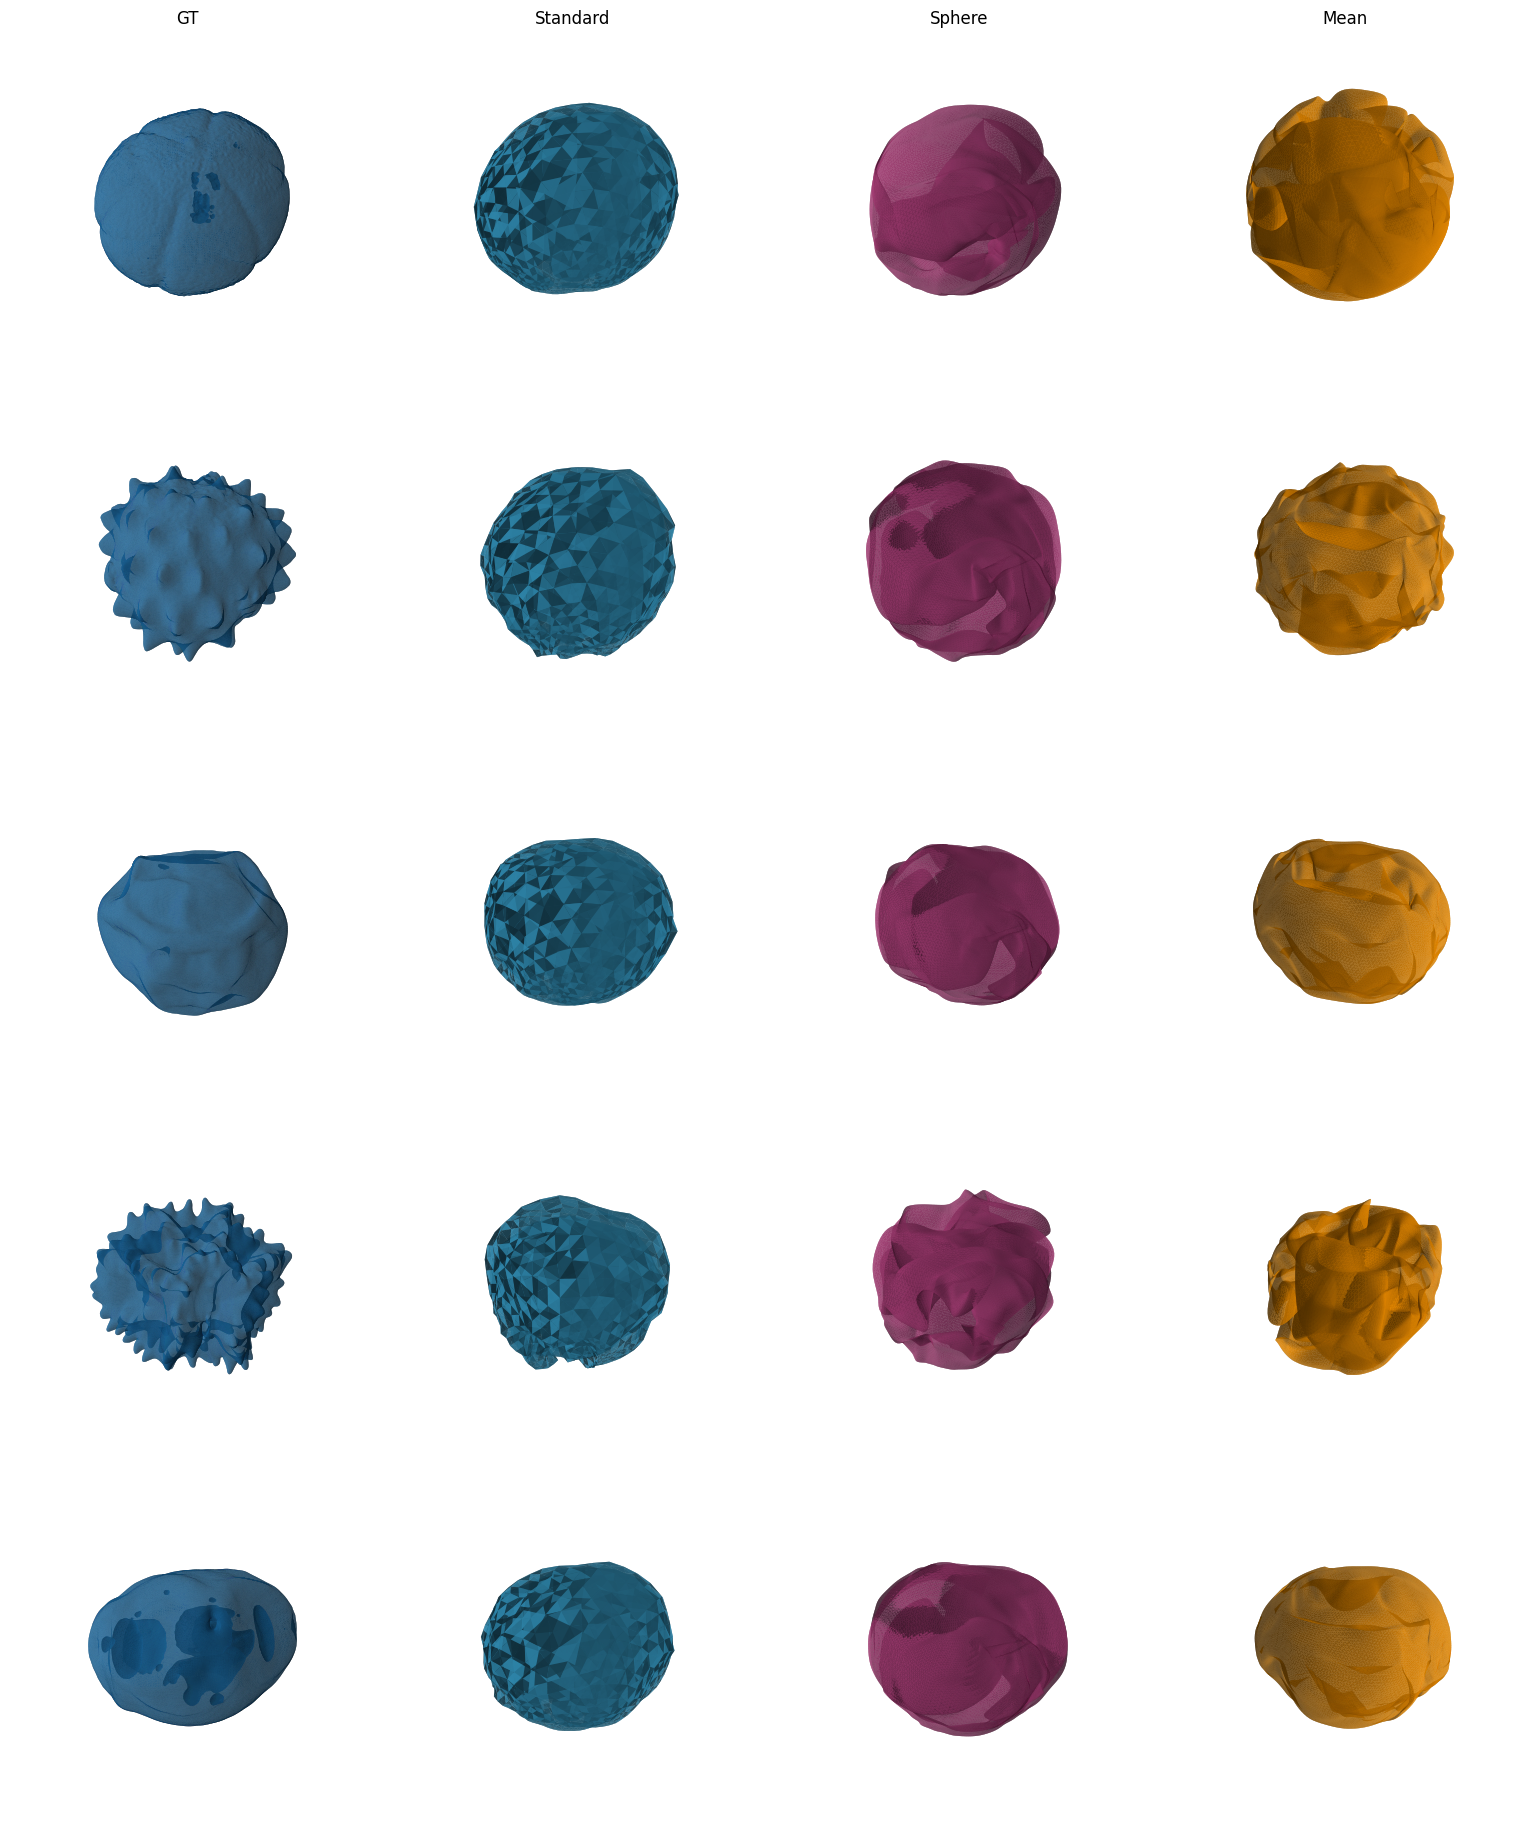

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import trimesh
import numpy as np
import os

# Define the filenames and prior directories
filenames = [
    "17781_Common_thyme_Thymus_vulgaris_pollen_grain",
    "17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain",
    "21555_Hard_rush_Juncus_inflexus_pollen_grain_shrunken",
    "21188_Meadow_goats_beard_Tragopogon_pratensis_pollen_grain",
    "17878_Alder_Alnus_sp_pollen_grain_pentaporate",
]

prior_dirs = {
    "GT": None,  # Ground truth will be loaded from different path
    "Standard": "refine_p2mpp_augmentation_2_inputs",
    "Sphere": "refine_p2mp_augmentation_2_inputs_use_spherical_prior",
    "Mean": "refine_p2mpp_augmentation_2_inputs_use_mean_prior",
}

base_path = "../TestEvaluationPipeline/data/smoothed_obj_files"
gt_path = "../data/processed/interim"
colors = [
    "#1b669b",
    "#2E86AB",
    "#A23B72",
    "#F18F01",
]  # Blue for GT, Green, Magenta, Yellow for priors

# Create figure with subplots (5 rows x 4 columns now including GT) - more compact
fig = plt.figure(figsize=(16, 20))

for i, filename in enumerate(filenames):
    for j, (prior_name, prior_dir) in enumerate(prior_dirs.items()):
        # Create subplot
        ax = fig.add_subplot(5, 4, i * 4 + j + 1, projection="3d")

        try:
            if prior_name == "GT":
                # Load ground truth .stl file
                gt_filename = f"{filename}.stl"
                file_path = os.path.join(gt_path, gt_filename)
                mesh = trimesh.load_mesh(file_path)
            else:
                # Try to load prediction .obj file - first try smoothed, then non-smoothed
                obj_filename_smoothed = f"pollen_{filename}_00_predict_smoothed.obj"
                obj_filename_regular = f"pollen_{filename}_00_predict.obj"

                file_path_smoothed = os.path.join(
                    base_path, prior_dir, obj_filename_smoothed
                )
                file_path_regular = os.path.join(
                    base_path, prior_dir, obj_filename_regular
                )

                # Try smoothed version first
                if os.path.exists(file_path_smoothed):
                    file_path = file_path_smoothed
                    mesh = trimesh.load_mesh(file_path)
                elif os.path.exists(file_path_regular):
                    file_path = file_path_regular
                    mesh = trimesh.load_mesh(file_path)
                else:
                    raise FileNotFoundError(
                        f"Neither smoothed nor regular version found"
                    )

            # Plot the mesh
            ax.plot_trisurf(
                mesh.vertices[:, 0],
                mesh.vertices[:, 1],
                mesh.vertices[:, 2],
                triangles=mesh.faces,
                color=colors[j],
                alpha=0.8,
            )

            # Set title - only show prior name in header row with reduced padding
            if i == 0:  # First row: show prior names only
                ax.set_title(f"{prior_name}", fontsize=12, pad=2)

            # Remove axes
            ax.axis("off")

            # Set equal aspect ratio with tighter bounds
            x_range = ax.get_xlim3d()
            y_range = ax.get_ylim3d()
            z_range = ax.get_zlim3d()

            x_center = np.mean(x_range)
            y_center = np.mean(y_range)
            z_center = np.mean(z_range)

            # Reduce the margin around the mesh for tighter fit
            max_range = (
                max(
                    x_range[1] - x_range[0],
                    y_range[1] - y_range[0],
                    z_range[1] - z_range[0],
                )
                / 2.2  # Reduced from 2 to 2.2 for tighter bounds
            )

            ax.set_xlim3d([x_center - max_range, x_center + max_range])
            ax.set_ylim3d([y_center - max_range, y_center + max_range])
            ax.set_zlim3d([z_center - max_range, z_center + max_range])
            ax.set_box_aspect([1, 1, 1])

        except Exception as e:
            # If file doesn't exist or can't be loaded, show error message
            if prior_name == "GT":
                error_msg = f"GT file not found:\n{filename}.stl"
            else:
                error_msg = f"Files not found:\n{obj_filename_smoothed}\nor\n{obj_filename_regular}"

            ax.text(
                0.5,
                0.5,
                0.5,
                error_msg,
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=7,
            )
            ax.axis("off")

# Set transparent background and adjust layout for denser packing
fig.patch.set_alpha(0.0)
plt.subplots_adjust(
    hspace=0.02, wspace=0.02, left=0.02, right=0.98, top=0.95, bottom=0.05
)  # Much tighter spacing
plt.show()